# Import Libraries

In [62]:
import requests
import json
import pandas as pd
import ast

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import scipy.stats as stats


# Import helper files
import data_prep as dp
# import visualizations as viz
import hypothesis_tests as tests

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Obtain Data

NBA games data comes from the site https://www.balldontlie.io/#get-all-games

Without specifying any parameters, getting data through the site's API took ~12 minutes (factoring in my `time.sleep(0.8)` part of my function). So I saved the file as a csv in the 'data' folder.

In [2]:
# When I got data directly from the site

# url = 'https://www.balldontlie.io/api/v1/games'
# gamesDataOriginal = dp.getData(url)

In [3]:
# gamesDataOriginal.to_csv('data/gamesDataOriginal.csv', index=False)

In [3]:
gamesDataOriginal = pd.read_csv('data/gamesDataOriginal.csv')
gamesDataOriginal.head()

id                      date  \
0  47179  2019-01-30T00:00:00.000Z   
1  48751  2019-02-09T00:00:00.000Z   
2  48739  2019-02-08T00:00:00.000Z   
3  48740  2019-02-08T00:00:00.000Z   
4  48746  2019-02-08T00:00:00.000Z   

                                           home_team  home_team_score  period  \
0  {'id': 2, 'abbreviation': 'BOS', 'city': 'Bost...              126       4   
1  {'id': 2, 'abbreviation': 'BOS', 'city': 'Bost...              112       4   
2  {'id': 23, 'abbreviation': 'PHI', 'city': 'Phi...              117       4   
3  {'id': 30, 'abbreviation': 'WAS', 'city': 'Was...              119       4   
4  {'id': 26, 'abbreviation': 'SAC', 'city': 'Sac...              102       4   

   postseason  season status   time  \
0       False    2018  Final          
1       False    2018  Final          
2       False    2018  Final          
3       False    2018  Final          
4       False    2018  Final          

                                        visitor_team  visitor_team_score  
0  {'id': 4, 'abbreviation': 'CHA', 'city': 'Char...                  94  
1  {'id': 13, 'abbreviation': 'LAC', 'city': 'LA'...                 123  
2  {'id': 8, 'abbreviation': 'DEN', 'city': 'Denv...                 110  
3  {'id': 6, 'abbreviation': 'CLE', 'city': 'Clev...                 106  
4  {'id': 16, 'abbreviation': 'MIA', 'city': 'Mia...                  96

The values in  *'home_team'* and *'visitor_team'* columns are dictionaries. So I will create columns using the dictionary keys, and row values will be the dictionary values.

In [4]:
columnDictList = ['home_team', 'visitor_team']
gamesData = gamesDataOriginal.copy()

# In case you read in csv, dictionary is stored as a string
# So we have to convert it back to dictionary using ast.literal_eval()
for column in columnDictList:
    gamesData[column] = gamesData[column].apply(lambda x: ast.literal_eval(x))

# 'Split' out dictionary-like columns
gamesData = dp.convertDictColumns(gamesData, columnDictList)

# Remove the original dictionary-like columns
gamesData.drop(columns=columnDictList, inplace=True)
gamesData.head()

id                      date  home_team_score  period  postseason  \
0  47179  2019-01-30T00:00:00.000Z              126       4       False   
1  48751  2019-02-09T00:00:00.000Z              112       4       False   
2  48739  2019-02-08T00:00:00.000Z              117       4       False   
3  48740  2019-02-08T00:00:00.000Z              119       4       False   
4  48746  2019-02-08T00:00:00.000Z              102       4       False   

   season status   time  visitor_team_score  home_team_id  ...  \
0    2018  Final                         94             2  ...   
1    2018  Final                        123             2  ...   
2    2018  Final                        110            23  ...   
3    2018  Final                        106            30  ...   
4    2018  Final                         96            26  ...   

  home_team_division home_team_full_name home_team_name visitor_team_id  \
0           Atlantic      Boston Celtics        Celtics               4   
1           Atlantic      Boston Celtics        Celtics              13   
2           Atlantic  Philadelphia 76ers          76ers               8   
3          Southeast  Washington Wizards        Wizards               6   
4            Pacific    Sacramento Kings          Kings              16   

  visitor_team_abbreviation visitor_team_city  visitor_team_conference  \
0                       CHA         Charlotte                     East   
1                       LAC                LA                     West   
2                       DEN            Denver                     West   
3                       CLE         Cleveland                     East   
4                       MIA             Miami                     East   

  visitor_team_division visitor_team_full_name visitor_team_name  
0             Southeast      Charlotte Hornets           Hornets  
1               Pacific            LA Clippers          Clippers  
2             Northwest         Denver Nuggets           Nuggets  
3               Central    Cleveland Cavaliers         Cavaliers  
4             Southeast             Miami Heat              Heat  

[5 rows x 23 columns]

# Statistical Tests

## Has Scoring Changed Over Time?

### Create Dataframe

My score columns are split into *'home_team_score'* and *'visitor_team_score'*. I want to recreate my dataframe so that the scores (and any 'similar' columns are combined into one. I made a function to do so. 

I'll filter my dataframe to only look at games from 2013 to 2018 season.

To make sure that I'm comparing the same 'games', I'll only look at games that had 4 periods. This way, I'm excluding any overtime games in which teams have more time to score more points.

In [18]:
gamesDataLong = dp.makeLongDF(gamesData)

# Filter for seasons
t_min = 2013
t_max = 2018
gamesDataLong = gamesDataLong.loc[(gamesDataLong['season']>=t_min)&(gamesDataLong['season']<=t_max)]

# Filter for 4 period games
gamesDataLong = gamesDataLong.loc[gamesDataLong['period']==4]

To verify that the data was split and concatenated appropriately, let's take a game id. When I filter for a game id, I should get 1 row returned from original dataframe and 2 rows returned from the new long dataframe.

In [19]:
gamesData.loc[gamesData['id']==47179, ['id', 'home_team_name', 'home_team_score', 'visitor_team_name', 'visitor_team_score']]

id home_team_name  home_team_score visitor_team_name  visitor_team_score
0  47179        Celtics              126           Hornets                  94

In [20]:
gamesDataLong.loc[gamesData['id']==47179, ['id', 'team_name', 'team_score']]

id team_name  team_score
0  47179   Celtics         126
0  47179   Hornets          94

### Visualize Data

#### Descriptive Stats

In [25]:
gamesDataLong.groupby('season')['team_score'].describe()

count        mean        std   min    25%    50%    75%    max
season                                                                 
2013    2638.0  100.910159  11.856584  63.0   93.0  101.0  109.0  145.0
2014    2622.0  100.047292  11.765905  65.0   92.0  100.0  107.0  144.0
2015    2632.0  102.485562  11.827203  68.0   94.0  102.0  111.0  147.0
2016    2618.0  105.618029  12.165714  64.0   97.0  106.0  114.0  149.0
2017    2624.0  106.215320  12.037515  69.0   98.0  106.0  114.0  149.0
2018    2570.0  110.580156  12.383831  68.0  102.0  111.0  119.0  154.0

#### Boxplot

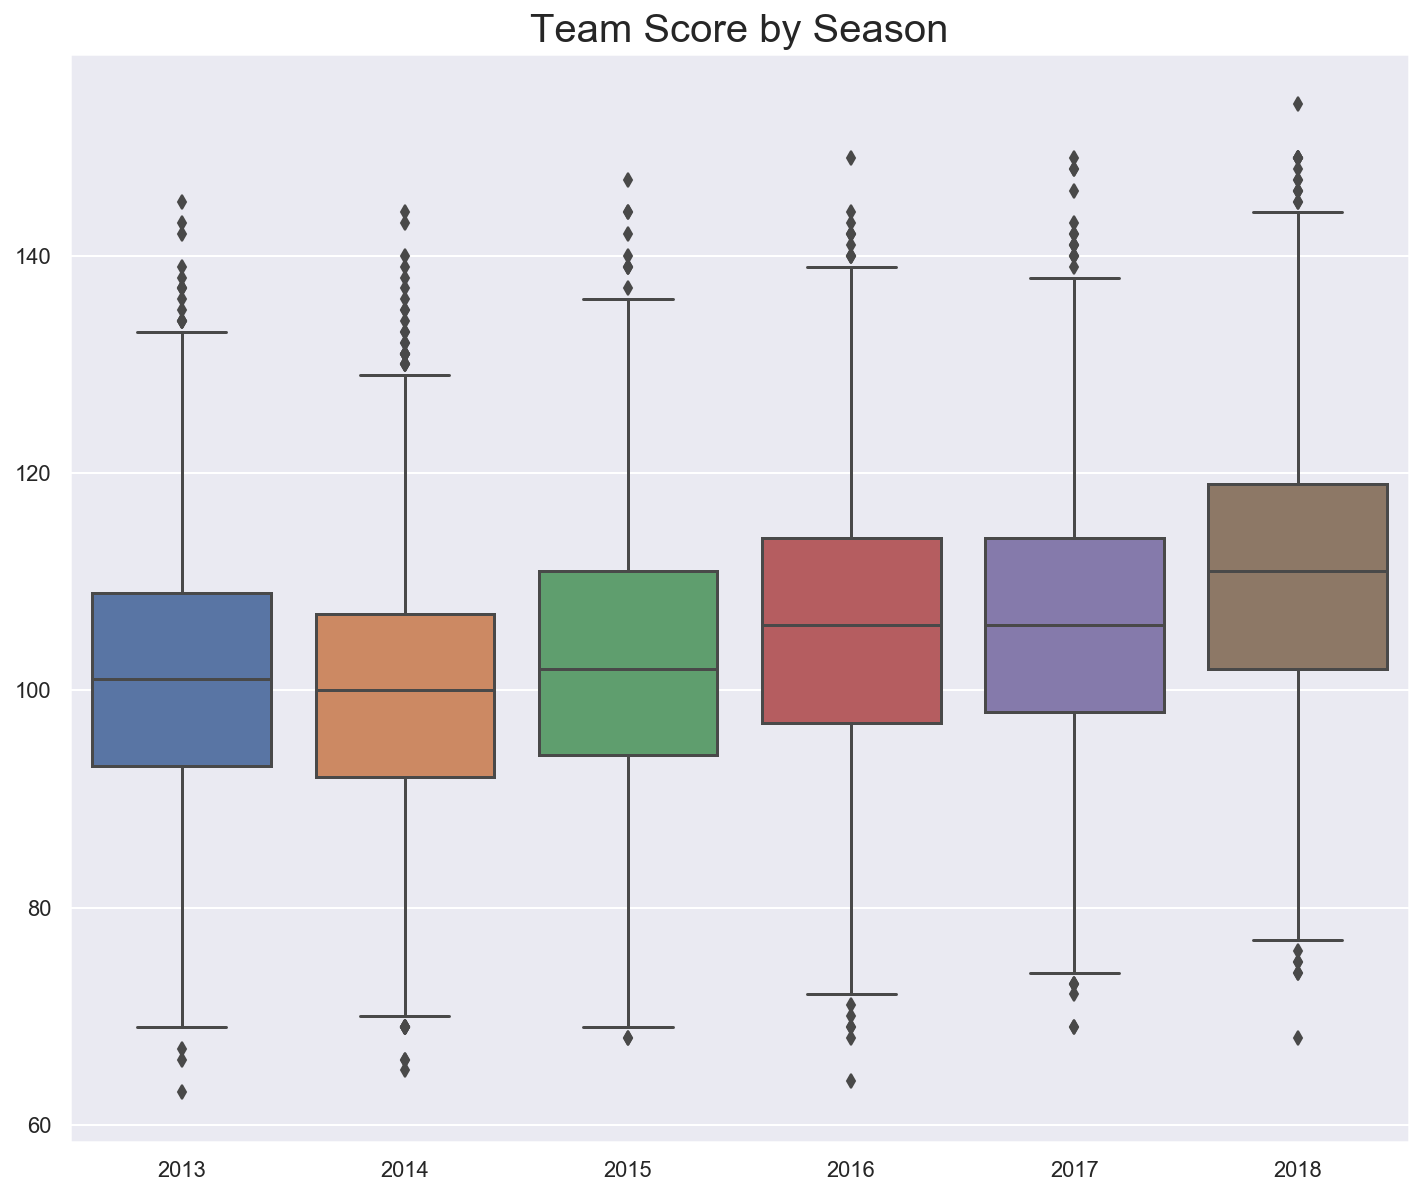

In [28]:
xCol='season'
yCol='team_score'

fig = sns.boxplot(x=xCol, y=yCol, data=gamesDataLong)
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})


# Clean column names for title and labels
xLabel = xCol.replace('_',' ').strip().title()
yLabel = yCol.replace('_',' ').strip().title()

fig.set_xlabel('')
fig.set_ylabel('')
fig.set_title(f"{yLabel} by {xLabel}", fontsize=20);

Season-to-season, it looks like there is a jump in score from 2015 to 2016 and from 2017 to 2018.

#### Distplots

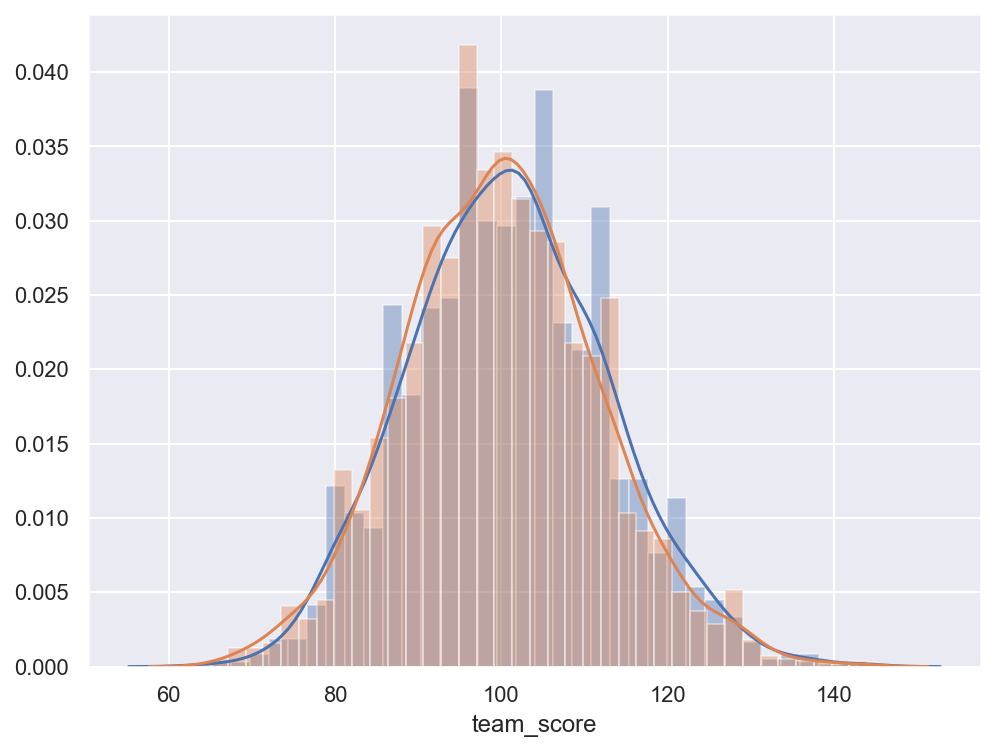

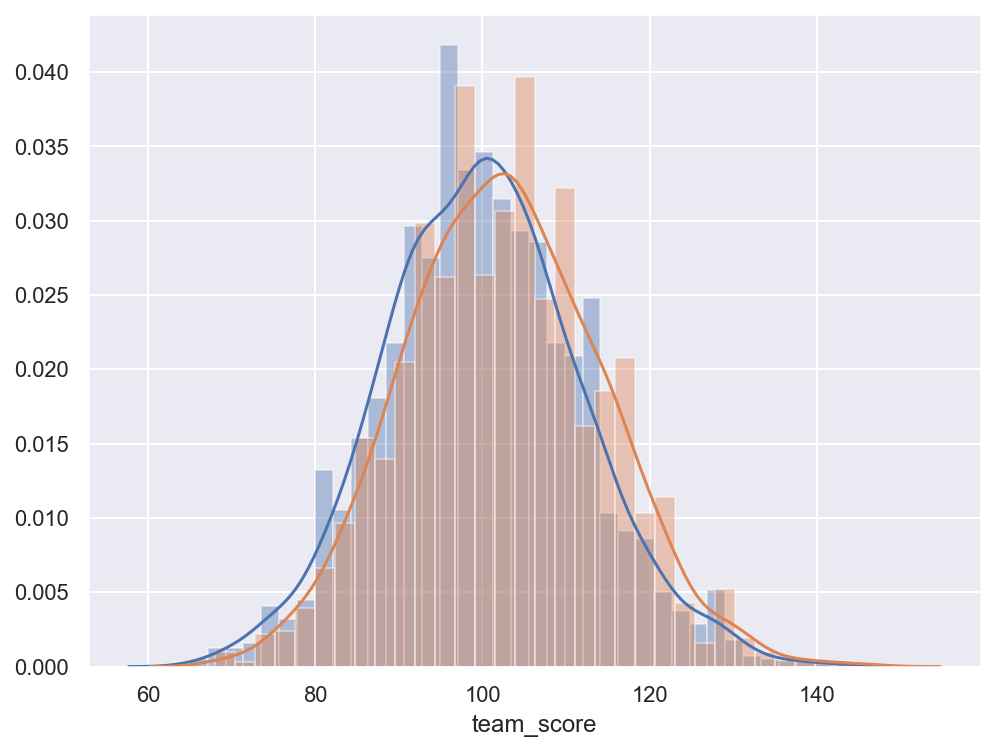

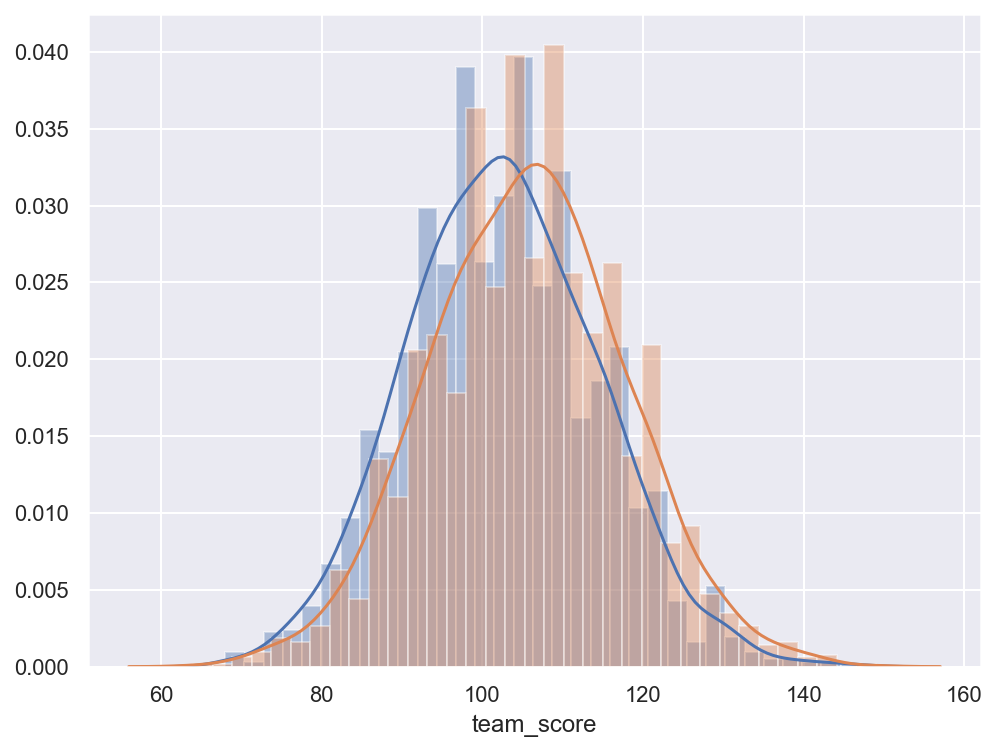

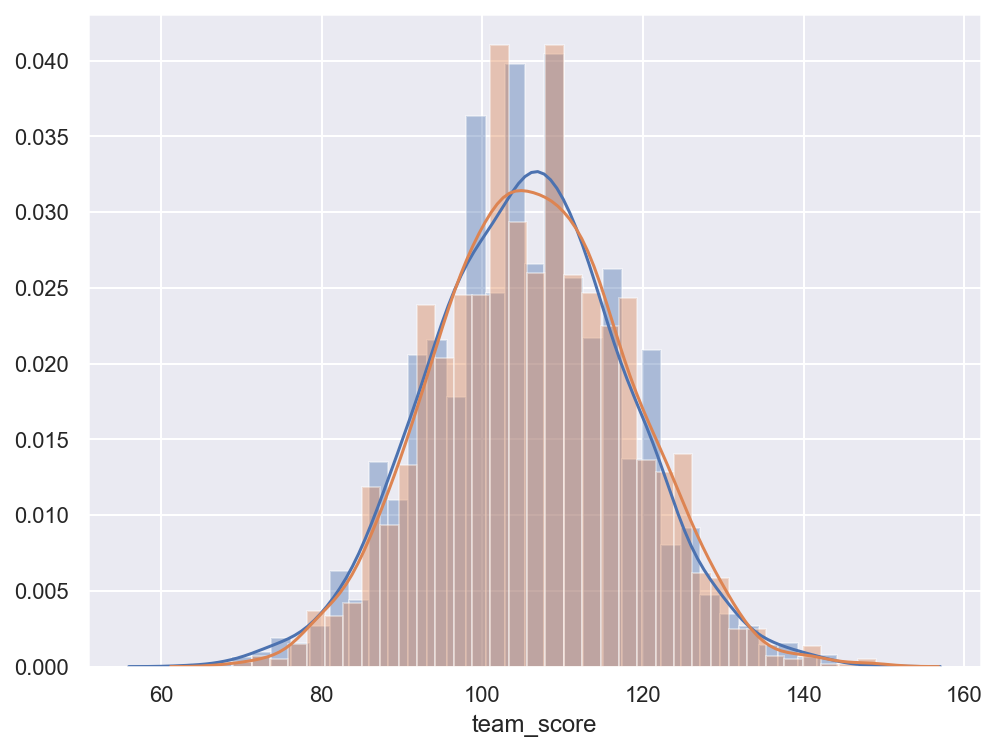

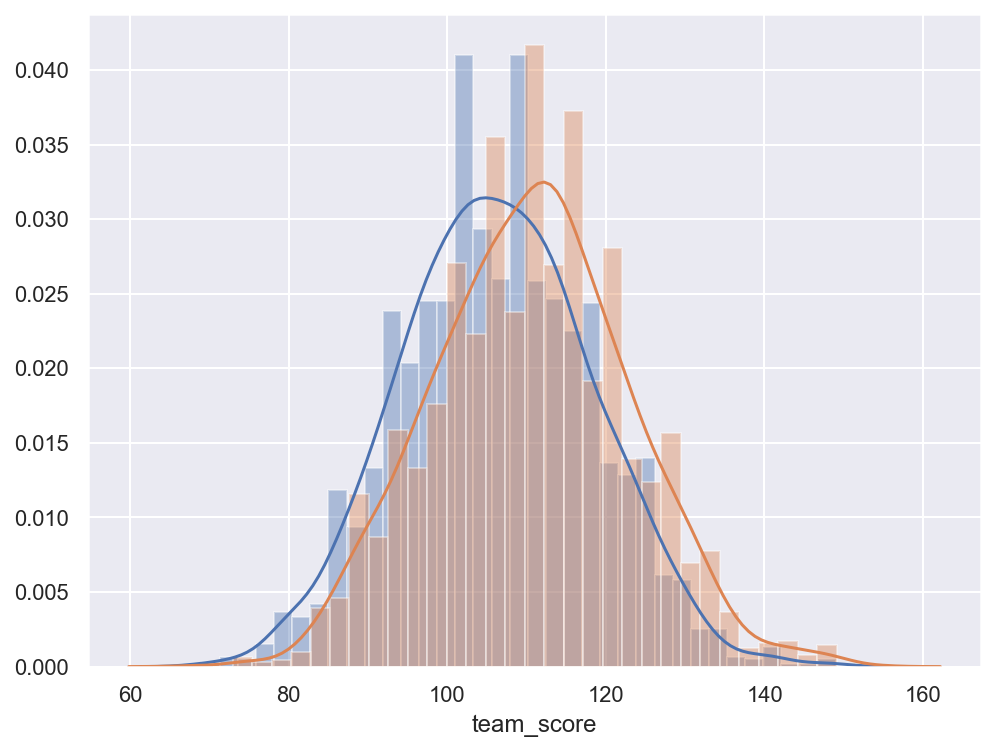

In [59]:
for s, season in enumerate(range(t_min, t_max)):
    
    seasonScores = gamesDataLong.loc[gamesData['season']==season, 'team_score']
    seasonScores_1 = gamesDataLong.loc[gamesData['season']==(season+1), 'team_score']
    
    plt.figure(s)
    sns.set(color_codes=True)
    sns.set(rc={'figure.figsize':(8,6)})
    sns.distplot(seasonScores)
    sns.distplot(seasonScores_1)

###  Conduct the Test

I will use an **independent t-test** (also known as two sample t-test, student's t-test and unpaired t-test) to test for a significant difference in the mean scores between two consecutive seasons.

#### Set up Hypotheses

Let $\mu_t$ represent the average score in season *t*, where *t* is in a user-defined range [$t_{min}$, $t_{max}$]

So our Null ($H_0$) and Alternative ($H_A$) hypotheses are:

$H_0$: $\mu_t$ = $\mu_{t-1}$, there is no difference in overall points scored between seasons *t* and *t-1*

$H_A$: $\mu_t$ != $\mu_{t-1}$, there is a significant difference in overal points scored between years *t* and *t-1*

**Note:** Even though I may have more than 2 seasons in my range of seasons, I will only conduct t-tests between two seasons. For instance, if I conduct tests for seasons 2013 through 2015, I will conduct 2 t-tests: one for 2013/2014 and one for 2014/2015. These tests will be independent from one another.

#### Choose Significance Level: alpha

alpha $\alpha$
- Marginal threshold at which I'm okay with rejecting the null hypothesis
- Typically, this is set at 0.05, which is what I will do
- *"I'm okay with accepting my alternative hypothesis as true if there is less than a 5% chance that the results that I'm seeing are actually due to randomness."*

#### Calculate Test Statistic

When comparing the difference between groups, we can calculate the two-sample t-statistic like so:

$$\large t = \frac{\bar{x}_{1} - \bar{x}_{2}}{\sqrt{s^{2}_{p} (\frac{1}{n_{1}} + \frac{1}{n_{2}}) }    }  $$

Where $s^{2}_{p}$ is the pooled sample variance, calculated as:

$$\large s^{2}_{p}  = \frac{(n_{1} -1)s^{2}_{1} +  (n_{2} -1)s^{2}_{2}}{n_{1} + n_{2} - 2}  $$

Where $s^{2}_{1}$ and $s^{2}_{2}$ are the variances for each sample given by the formula 
$$ \large s^{2} = \frac{\sum_{i=1}^{n}(x_{i} - \bar{x})^{2}}{n-1} $$

The $s^2_{p}$ denotes the sample variance. In this version of the t-test I am assuming equal variances between seasons. 

In [65]:
for season in range(t_min, t_max):
    
    seasonScores = gamesDataLong.loc[gamesData['season']==season, 'team_score']
    seasonScores_1 = gamesDataLong.loc[gamesData['season']==(season+1), 'team_score']
    
    t_stat = tests.twosample_tstatistic(seasonScores_1, seasonScores)
    print(f"Between {season} and {season+1}: {t_stat}")
    

Between 2013 and 2014: -2.6491151108885598
Between 2014 and 2015: 7.490956961340492
Between 2015 and 2016: 9.459205237490416
Between 2016 and 2017: 1.786724084670686
Between 2017 and 2018: 12.880898698405813


#### Determine Test Result

$p$-value
- Probability of observing a test statistic at least as large as the one observed, by random chance, assuming that the null hypothesis is true
- Example: *If I calculate a p-value and it comes out to 0.03, you can interpret this as saying "There is a 3% chance that the results I'm seeing are actually due to randomness or pure luck".*

Comparing $p$ and $\alpha$
- $p < \alpha$: Reject $H_0$ and accept the$H_A$

- $p >= \alpha$: Fail to reject the $H_0$  

In [67]:
for season in range(t_min, t_max):
    
    seasonScores = gamesDataLong.loc[gamesData['season']==season, 'team_score']
    seasonScores_1 = gamesDataLong.loc[gamesData['season']==(season+1), 'team_score']
    
    t_test = stats.ttest_ind(seasonScores_1, seasonScores)
    print(f"Between {season} and {season+1}: {t_test}")
    

Between 2013 and 2014: Ttest_indResult(statistic=-2.6491151108885598, pvalue=0.008094416132709992)
Between 2014 and 2015: Ttest_indResult(statistic=7.490956961340492, pvalue=7.97647541162849e-14)
Between 2015 and 2016: Ttest_indResult(statistic=9.459205237490416, pvalue=4.562453451948647e-21)
Between 2016 and 2017: Ttest_indResult(statistic=1.786724084670686, pvalue=0.07403988485626768)
Between 2017 and 2018: Ttest_indResult(statistic=12.880898698405813, pvalue=2.1447675024320503e-37)


### Visualize Test

In [11]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
xs = np.linspace(-4, 4, 500)
ys = stats.t.pdf(xs, 500, 0, 1)
crit = stats.t.ppf(1-0.025, (n_control+n_experimental-2))

ax.plot(xs, ys, linewidth=3, color='darkred')
ax.axvline(crit, color='black', linestyle='--', lw=5)
ax.axvline(-crit, color='black', linestyle='--', lw=5)

plt.fill_betweenx(y=.05,x1=-2,x2=-4,color='b')
# plt.fill_betweenx(female_ys,x1=f_xs,x2=thresh, where = f_xs > thresh,color='b')


NameError: name 't_stat' is not defined

In [ ]:
# generate points on the x axis between -5 and 5:
xs = np.linspace(-5, 5, 200)

# use stats.t.pdf to get values on the probability density function for the t-distribution
# the second argument is the degrees of freedom
ys = stats.t.pdf(xs, df, 0, 1)

# initialize a matplotlib "figure"
fig = plt.figure(figsize=(8,5))

# get the current "axis" out of the figure
ax = fig.gca()

# plot the lines using matplotlib's plot function:
ax.plot(xs, ys, linewidth=3, color='darkblue')

# plot a vertical line for our measured difference in rates t-statistic
ax.axvline(t, color='red', linestyle='--', lw=5,label='t-statistic')
ax.legend()
plt.show()

## Do Teams Have Home Court Advantage?

Do certain teams win by a larger margin when playing on home court?

### Create Dataframe

I'll take the original dataframe, and create a column by taking the difference in home team score and visitor team score. I'll filter for a particlar season

In [69]:
gamesDataHome = gamesData.copy()

# Create column
gamesDataHome['home_diff'] = gamesDataHome['home_team_score'] - gamesDataHome['visitor_team_score']

# Filter for season
gamesDataHome = gamesDataHome.loc[gamesDataHome['season']==2018]

gamesDataHome.loc[:,['id', 'date', 'home_team_name', 'home_team_score', 'visitor_team_name', 'visitor_team_score', 'home_diff']].head()

id                      date home_team_name  home_team_score  \
0  47179  2019-01-30T00:00:00.000Z        Celtics              126   
1  48751  2019-02-09T00:00:00.000Z        Celtics              112   
2  48739  2019-02-08T00:00:00.000Z          76ers              117   
3  48740  2019-02-08T00:00:00.000Z        Wizards              119   
4  48746  2019-02-08T00:00:00.000Z          Kings              102   

  visitor_team_name  visitor_team_score  home_diff  
0           Hornets                  94         32  
1          Clippers                 123        -11  
2           Nuggets                 110          7  
3         Cavaliers                 106         13  
4              Heat                  96          6

### Visualize Data

#### Descriptive Stats

In [70]:
gamesDataHome.groupby('home_team_name')['home_diff'].describe()

count       mean        std   min    25%   50%    75%   max
home_team_name                                                             
76ers            47.0   8.319149  12.460558 -15.0  -0.50   7.0  18.00  42.0
Bucks            49.0  12.224490  14.237956 -22.0   6.00  14.0  21.00  43.0
Bulls            41.0  -9.804878  13.946719 -56.0 -19.00  -7.0  -1.00  12.0
Cavaliers        41.0  -7.341463  15.650255 -36.0 -19.00  -9.0   5.00  25.0
Celtics          45.0   6.155556  13.249281 -19.0  -5.00   7.0  13.00  33.0
Clippers         44.0   1.818182  15.658080 -32.0  -6.50   4.5  11.75  32.0
Grizzlies        41.0   0.439024  10.124349 -23.0  -8.00   1.0   9.00  21.0
Hawks            41.0  -4.024390  12.424749 -31.0 -15.00  -5.0   5.00  24.0
Heat             41.0   0.243902  13.992463 -23.0 -10.00  -2.0   7.00  34.0
Hornets          41.0   3.682927  13.543336 -38.0  -4.00   5.0  12.00  32.0
Jazz             43.0   7.790698  15.386386 -33.0  -2.00   8.0  17.00  34.0
Kings            41.0   1.439024  11.975076 -26.0  -5.00   4.0   9.00  27.0
Knicks           41.0  -7.853659  11.448932 -28.0 -15.00  -8.0  -2.00  19.0
Lakers           41.0  -0.170732  10.725909 -19.0  -8.00   1.0   7.00  24.0
Magic            43.0   1.906977  16.803931 -39.0  -6.50   3.0  10.00  38.0
Mavericks        41.0   2.341463  12.885282 -30.0  -5.00   3.0   8.00  50.0
Nets             43.0   1.953488  13.474762 -19.0  -8.50   1.0   7.50  39.0
Nuggets          48.0   9.833333  14.287822 -31.0   2.00   8.5  18.75  45.0
Pacers           43.0   7.000000  16.313885 -32.0  -4.50   8.0  15.50  42.0
Pelicans         41.0  -0.878049  14.005704 -30.0 -10.00  -2.0   9.00  26.0
Pistons          43.0   1.534884  12.509708 -27.0  -7.00   4.0   9.00  26.0
Raptors          54.0   8.037037  11.676396 -16.0   2.00   8.5  16.00  36.0
Rockets          47.0   7.531915  13.142780 -20.0   2.00   7.0  16.00  36.0
Spurs            44.0   6.681818  13.021936 -31.0   1.75   7.0  13.00  38.0
Suns             41.0  -6.292683  12.570290 -30.0 -16.00  -7.0   4.00  21.0
Thunder          43.0   4.813953  11.934855 -22.0  -3.50   6.0  12.50  25.0
Timberwolves     41.0   2.878049  12.930961 -30.0  -6.00   3.0  10.00  39.0
Trail Blazers    49.0   7.510204  11.970663 -30.0   3.00   7.0  13.00  34.0
Warriors         52.0   5.500000  17.509101 -35.0  -4.00   6.0  17.00  47.0
Wizards          41.0   1.756098  11.512559 -23.0  -6.00   3.0  10.00  24.0

#### Boxplot

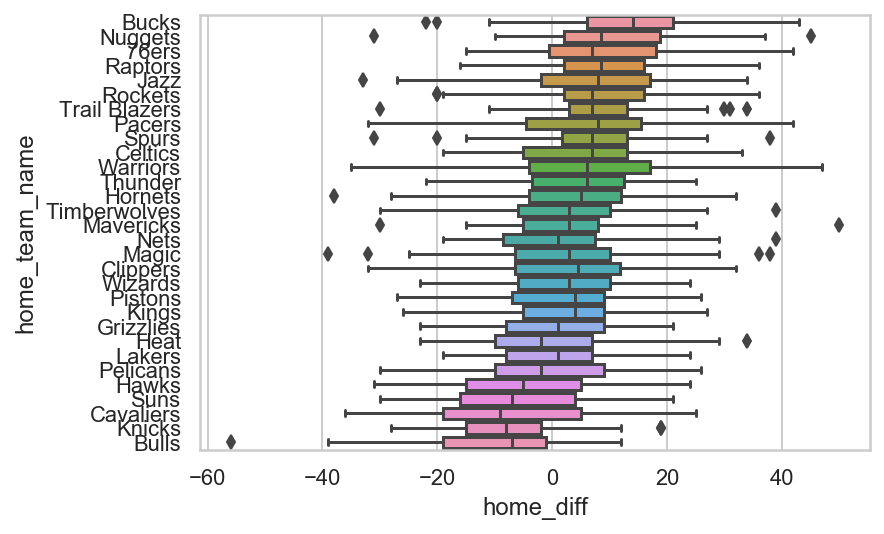

In [71]:
# Set order for boxplots
my_order = gamesDataHome.groupby("home_team_name")["home_diff"].mean().sort_values(ascending=False).index


sns.boxplot(y='home_team_name', x='home_diff', data=gamesDataHome, orient='h', order=my_order);

### Define the Test

Let $d_i$ be the average score differential of team *i*, where *i* ranges from *1,...,n*. So our hypotheses are:

Null hypothesis $H_0$: $d_1$=$d_2$ =...=$d_n$=0, no team has a significant home court advantage

Alternative hypothesis $H_A$: at least one $d_i$ is different, there exists at least 1 team with a significant home court advantage

If $H_0$ is rejected, then I will conduct a t-test to determine which team

In [72]:
tests.conduct_anova(gamesDataHome, 'home_team_name', 'home_diff')

F:  7.12
p-value:  0.0
At least 1 team's home court advantage is statistically significant 

Celtics's home court advantage is statistically significantly
 better than
Pelicans's (t-stat: 2.39, p-value: 0.0189)
Celtics's home court advantage is statistically significantly
 better than
Hawks's (t-stat: 3.67, p-value: 0.0004)
Celtics's home court advantage is statistically significantly
 better than
Bulls's (t-stat: 5.44, p-value: 0.0)
Celtics's home court advantage is statistically significantly
 worse than
Bucks's (t-stat: -2.13, p-value: 0.0355)
Celtics's home court advantage is statistically significantly
 better than
Grizzlies's (t-stat: 2.23, p-value: 0.0283)
Celtics's home court advantage is statistically significantly
 better than
Cavaliers's (t-stat: 4.33, p-value: 0.0)
Celtics's home court advantage is statistically significantly
 better than
Knicks's (t-stat: 5.22, p-value: 0.0)
Celtics's home court advantage is statistically significantly
 better than
Lakers's (t-stat: 2.42, 

Hawks's home court advantage is statistically significantly
 worse than
Trail Blazers's (t-stat: -4.47, p-value: 0.0)
Hawks's home court advantage is statistically significantly
 worse than
Hornets's (t-stat: -2.69, p-value: 0.0088)
Hawks's home court advantage is statistically significantly
 worse than
Nuggets's (t-stat: -4.84, p-value: 0.0)
Hawks's home court advantage is statistically significantly
 worse than
Nets's (t-stat: -2.11, p-value: 0.0378)
Hawks's home court advantage is statistically significantly
 worse than
Thunder's (t-stat: -3.33, p-value: 0.0013)
Hawks's home court advantage is statistically significantly
 worse than
Spurs's (t-stat: -3.87, p-value: 0.0002)
Jazz's home court advantage is statistically significantly
 better than
Bulls's (t-stat: 5.48, p-value: 0.0)
Jazz's home court advantage is statistically significantly
 better than
Grizzlies's (t-stat: 2.57, p-value: 0.0119)
Jazz's home court advantage is statistically significantly
 better than
Cavaliers's (t-sta

Knicks's home court advantage is statistically significantly
 worse than
Heat's (t-stat: -2.87, p-value: 0.0053)
Knicks's home court advantage is statistically significantly
 worse than
Thunder's (t-stat: -4.96, p-value: 0.0)
Knicks's home court advantage is statistically significantly
 worse than
Spurs's (t-stat: -5.45, p-value: 0.0)
Knicks's home court advantage is statistically significantly
 worse than
Clippers's (t-stat: -3.23, p-value: 0.0018)
Magic's home court advantage is statistically significantly
 worse than
Nuggets's (t-stat: -2.43, p-value: 0.017)
Magic's home court advantage is statistically significantly
 better than
Suns's (t-stat: 2.52, p-value: 0.0136)
Trail Blazers's home court advantage is statistically significantly
 better than
Lakers's (t-stat: 3.18, p-value: 0.0021)
Trail Blazers's home court advantage is statistically significantly
 better than
Nets's (t-stat: 2.09, p-value: 0.039)
Trail Blazers's home court advantage is statistically significantly
 better tha

## East vs West (OLD)

I'd like to conduct a test to determine which conference is better: East or West

I'll do the following:
1. Define the test
2. Create the appropriate dataframe
3. Check for assumptions
4. Run test and interpret results

### Define Test

Each game has two scores: score for team 1 (East) and score for team 2 (West). For games where an East team plays a West team, 

$H_0$
Null hypothesis: Mean Difference between East and West teams is 0; teams score relatively the same number of points per game.

Alternative hypothesis: Mean Difference is NOT 0; either East teams on average score more or score less than West teams.

### Set up dataframe

Using the 'conference' columns from the 'home_team' and 'visitor_team' columns to make columns in terms of East and West.

In [7]:
# Add columns to dataframe
eastWestDF = dp.makeEastWestDF(gamesData)

# Filter for one season
eastWestDF = eastWestDF.loc[eastWestDF['season']==2018]

eastWestDF.head()

id                      date  home_team_score  period  postseason  \
1   48751  2019-02-09T00:00:00.000Z              112       4       False   
2   48739  2019-02-08T00:00:00.000Z              117       4       False   
4   48746  2019-02-08T00:00:00.000Z              102       4       False   
12  48760  2019-02-10T00:00:00.000Z              143       4       False   
16  48759  2019-02-10T00:00:00.000Z              120       4       False   

    season status   time  visitor_team_score  home_team_id  ...  \
1     2018  Final                        123             2  ...   
2     2018  Final                        110            23  ...   
4     2018  Final                         96            26  ...   
12    2018  Final                        120            23  ...   
16    2018  Final                        118            10  ...   

   visitor_team_city visitor_team_conference visitor_team_division  \
1                 LA                    West               Pacific   
2             Denver                    West             Northwest   
4              Miami                    East             Southeast   
12       Los Angeles                    West               Pacific   
16             Miami                    East             Southeast   

   visitor_team_full_name visitor_team_name           east_team  east_score  \
1             LA Clippers          Clippers      Boston Celtics         112   
2          Denver Nuggets           Nuggets  Philadelphia 76ers         117   
4              Miami Heat              Heat          Miami Heat          96   
12     Los Angeles Lakers            Lakers  Philadelphia 76ers         143   
16             Miami Heat              Heat          Miami Heat         118   

                west_team west_score east_minus_west  
1             LA Clippers        123             -11  
2          Denver Nuggets        110               7  
4        Sacramento Kings        102              -6  
12     Los Angeles Lakers        120              23  
16  Golden State Warriors        120              -2  

[5 rows x 28 columns]

### Check Assumptions

#### Normal distribution

Let's plot the variable

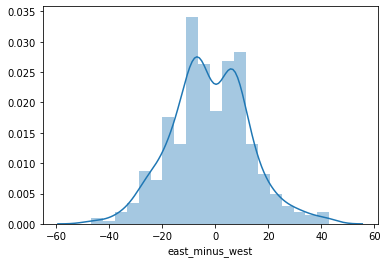

In [8]:
sns.distplot(eastWestDF['east_minus_west']);

In [ ]:
# stats.probplot(eastWestDF['east_minus_west'], plot=plt)

In [25]:
stats.shapiro(eastWestDF['east_minus_west'])

(0.9934282898902893, 0.044508881866931915)

#### Outliers

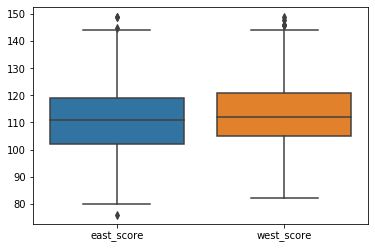

In [17]:
sns.boxplot(data=eastWestDF[['east_score', 'west_score']]);